# EE521 PROJECT SUBMISSION | TANYA CHAUDHARY , 204102317

# 2D discrete Fourier transform and 2D discrete wavelet transform for denoising white noise


### INTRODUCTION:
### The discrete wavelet transform is used to denoise white noise and also defines the edges of an image. In the project , the filtering in Fourier domain is performed with a Buterworth filter and in wavelet domain with the hard threshold with cycle spinning.

###  Importing Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import pywt
import copy
import pylab
from matplotlib.gridspec import GridSpec

###  Defining the various functions used for this project

In [2]:
def fft_wavenumbers(x, y, shape_dat, shape_pdat):# To compute the wavenumbers
    # x,y are 1D array along x and y direction 
    # shape_dat is a tuple of input shape 
    # shape_pdat tuple of shape of padding

    dx = (np.amax(x) - np.amin(x))/(shape_dat[0] - 1)
    dy = (np.amax(y) - np.amin(y))/(shape_dat[1] - 1)
    fx = 2*np.pi*np.fft.fftfreq(shape_pdat[0], dx)
    fy = 2*np.pi*np.fft.fftfreq(shape_pdat[1], dy)
    v,u=np.meshgrid(fy, fx)   # returns array and type of the wavenumber
    
    return (u,v)

def fft_pad_data(data, mode='edge'):#compute the 2D discrete Fourier transform and  padding is done
   

    n_points=int(2**(np.ceil(np.log(np.max(data.shape))/np.log(2))))
    nx, ny = data.shape    
    padx = int((n_points - nx)/2)
    pady = int((n_points - ny)/2)
    
    padded_data = np.pad(data, ((padx, padx), (pady, pady)),mode)    
    
    mask = np.zeros_like(padded_data, dtype=bool)# Mask to perform unpadding
    mask[padx:padx+data.shape[0], pady:pady+data.shape[1]] = True 
    fpdat = np.fft.fft2(padded_data)

    return (fpdat,mask)

def ifft_unpad_data(data_p, mask, shape_dat):# unpad the data to fit in the original shape
    # data_p is the 2D padded data
    # mask bool type to unpad the data
    
    ifft_data = np.real(np.fft.ifft2(data_p))
    data = ifft_data[mask]
    return np.reshape(data, shape_dat)
	
def butter2d_lp(shape, f, n): # 2D low pass butterworth filter
    # shape is tuple Size of the filter.
    # f is the float Relative cutoff frequency of the filter.
    # n  is the order of the filter
    
    rows, cols = shape 
    x = np.linspace(-0.5, 0.5, cols)
    y = np.linspace(-0.5, 0.5, rows)
    radius = np.sqrt((x**2)[np.newaxis] + (y**2)[:, np.newaxis]) 
    filt = 1 / (1.0 + (radius / f)**(2*n))
    
    return (filt)

def plot_wav(decomp): # Plot the data in DWT domain
   
    
    plt.figure(figsize=(10,10))
    gs = GridSpec(4, 4)
    
    ax = plt.subplot(gs[0, 0])
    plt.imshow(decomp[0])
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[1,0])
    plt.imshow(decomp[1][0])
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[0, 1])
    plt.imshow(decomp[1][1])
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[1, 1])
    plt.imshow(decomp[1][2])
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[2:,:2])
    plt.imshow(decomp[2][0])
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[:2,2:])
    plt.imshow(decomp[2][1])
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[2:,2:])
    plt.imshow(decomp[2][2])
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    
    return

### Load the image

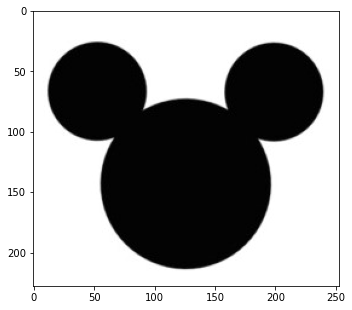

In [3]:
image = img.imread(r'mm_model.jpg')# Load the image
array = np.copy(image[:,:,0])# To retrieve only one 2D array from the image
plt.figure(figsize=(5,5))
plt.imshow(array, cmap=plt.cm.gray)
plt.tight_layout()

### Generate white noise and add it to the initial data

In [4]:
shape_dat=np.shape(array)

sigma = 0.03
sigma2=sigma*np.max(abs(array))
noise = np.random.normal(sigma2, size=(shape_dat))

data=array+noise

### Plot the initial , noise and noisy data

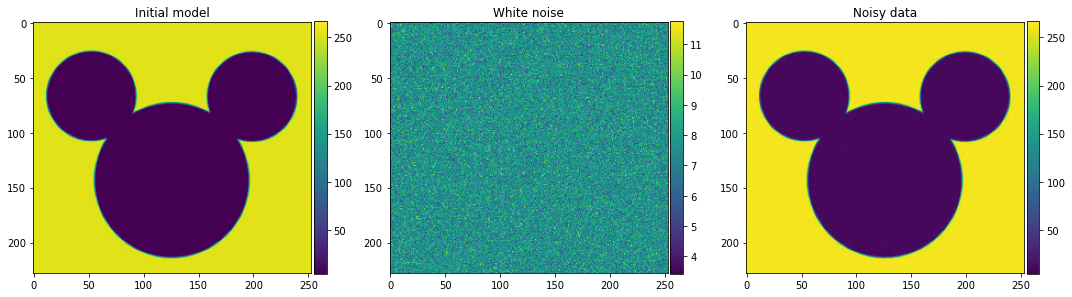

In [5]:
plt.figure(figsize=(15,5))

minplt = np.min(data)
maxplt = np.max(data)

ax=plt.subplot(1,3,1)
plt.imshow(array, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.title('Initial model')
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,2)
plt.title('White noise')
plt.imshow(noise, cmap=plt.cm.viridis)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,3)
plt.title('Noisy data')
plt.imshow(data, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

plt.tight_layout()


In [6]:
x=np.arange(0.,data.shape[0],1.) # To prepare the coordinates
y=np.arange(0.,data.shape[1],1.)
Y,X=np.meshgrid(y,x)


In [7]:
anom_FFT, mask = fft_pad_data(data)
shape_pdat=anom_FFT.shape
# Fourier wavenumbers
u, v = fft_wavenumbers(X, Y, shape_dat, shape_pdat)
# Center the anomaly 
anom_FFT_shift=np.fft.fftshift(anom_FFT)
minsize=int(np.min(np.log10(abs(anom_FFT_shift))))
maxsize=int(np.max(np.log10(abs(anom_FFT_shift))))
# Draw the Butterworth filter
freq=0.15
order=4
filt=butter2d_lp(anom_FFT_shift.shape, freq,order)
# Filter the noisy data in Fourier domain
anom_filt_fft = anom_FFT_shift * filt
# Filtered data
filtered_fft =ifft_unpad_data(np.fft.ifftshift(anom_filt_fft),  mask, shape_dat)

### Plot the noisy data in fourier domain , butterworth filter and filtered data 

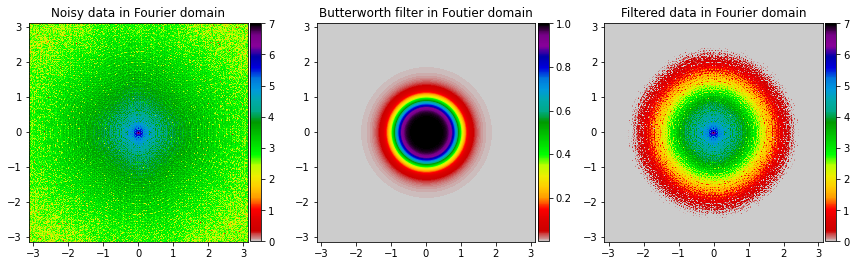

In [8]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,3,1)
plt.title('Noisy data in Fourier domain')
plt.imshow(np.log10(abs(anom_FFT_shift)),cmap=plt.cm.nipy_spectral_r,interpolation='nearest',\
           extent=[v.min(),v.max(),u.min(),u.max()],vmin=minsize,vmax=maxsize)
plt.colorbar(pad=0.01,fraction=0.047)

ax=plt.subplot(1,3,2)
plt.title('Butterworth filter in Foutier domain')
plt.imshow(filt,cmap=plt.cm.nipy_spectral_r,extent=[v.min(),v.max(),u.min(),u.max()])
plt.colorbar(pad=0.01,fraction=0.047)

ax=plt.subplot(1,3,3)
plt.title('Filtered data in Fourier domain')
plt.imshow(np.log10(abs(anom_filt_fft)),cmap=plt.cm.nipy_spectral_r,interpolation='nearest',\
           extent=[v.min(),v.max(),u.min(),u.max()],vmin=minsize,vmax=maxsize)
plt.colorbar(pad=0.01,fraction=0.047)

plt.tight_layout()

### Plot  the noisy data , Filtered data after DFT and the residual image from both of these

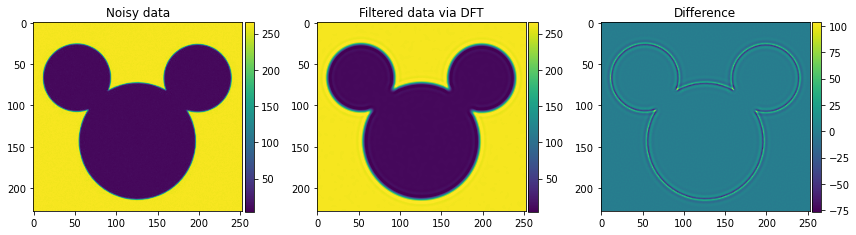

In [9]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,3,1)
plt.title('Noisy data')
plt.imshow(data, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,2)
plt.title('Filtered data via DFT')
plt.imshow(filtered_fft, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,3) # Plot the residuals
plt.title('Difference')
plt.imshow(data-filtered_fft, cmap=plt.cm.viridis)
plt.colorbar(pad=0.01,fraction=0.043)

plt.tight_layout()

### 2D DWT

In [10]:
wav = 'coif4'
wavelet=pywt.Wavelet(wav)
# number of scales to decompose the data
scales=2
# 2D wavelet deconposition
decomp = pywt.wavedec2(data,wav,level=scales)

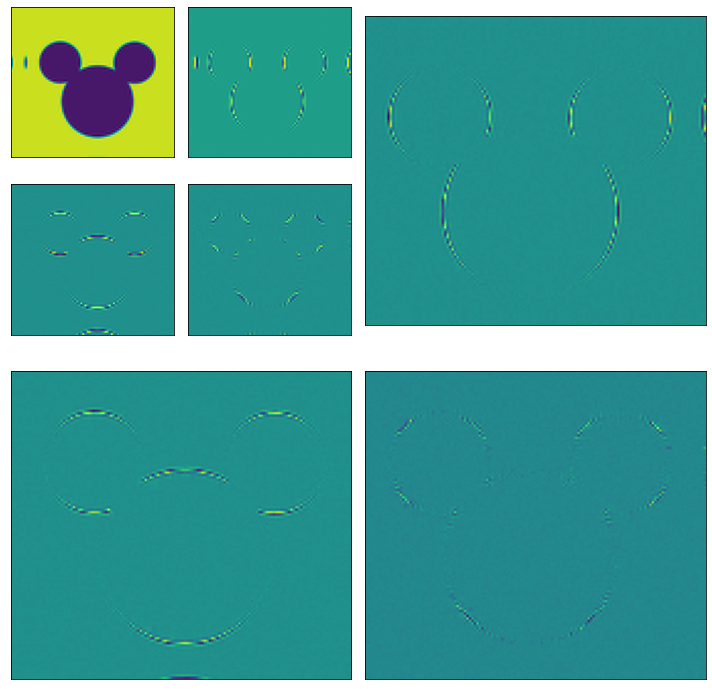

In [11]:
plot_wav(decomp) # Plot the data in discrete wavelet domain

###  Perform the filtering in wavelet domain with hard thresholding

In [12]:
m,n=np.shape(data)
filt_dwt = np.zeros_like(data)

#Generate a set of shifts 
for i in range(0,min(m,n)):
    fS = np.roll(data,i,axis=0) #this is the circular shift for the cycle spinning, one shift per iteration
    decomp = pywt.wavedec2(fS,wav,level=scales)
    decompclean = copy.deepcopy(decomp) #safe copy
    det = np.c_[decomp[-1][:]] #finest scale
    sigma = np.median(abs(det))/0.6745  
    thresh = sigma*np.sqrt(2*np.log(len(data))) #define the threshold for filtering
    for j in range(1,len(decomp)):
        decompclean[j] = tuple(pywt.threshold(decompclean[j],thresh,'hard')) #perform the filtering
    fS = pywt.waverec2(decompclean,wav) #reconstruct the data to the original domain
    fS = np.roll(fS[:,:-1],-i,axis=0) # unshift the data
    filt_dwt = i/(i+1.0)*filt_dwt + 1.0/(i+1)*fS #finishes the cycle spinning with weighting

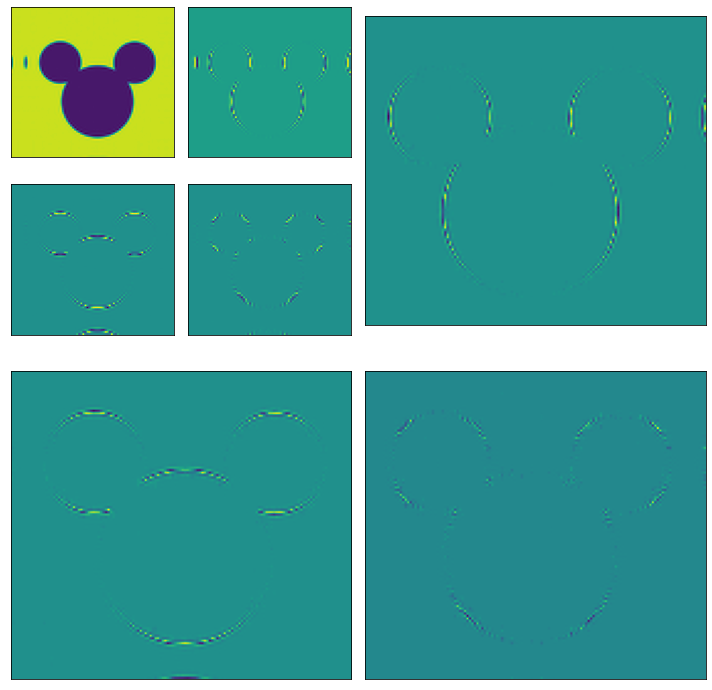

In [13]:
decomp2 = pywt.wavedec2(filt_dwt,wav,level=scales)

plot_wav(decomp2)

### Plot the Noisy data , Filtered data via DWT and the residual image for these two data

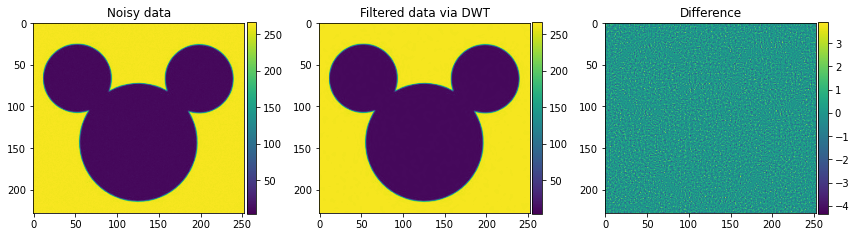

In [14]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,3,1)
plt.title('Noisy data')
plt.imshow(data, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,2)
plt.title('Filtered data via DWT')
plt.imshow(filt_dwt, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,3)
plt.title('Difference')
plt.imshow(data-filt_dwt, cmap=plt.cm.viridis)
plt.colorbar(pad=0.01,fraction=0.043)

plt.tight_layout()